In [1]:
%run ./utils.ipynb

In [2]:
# noisy_x_train = tf.convert_to_tensor(load('resources/trojan_injected_mnist_x_train.npy'))
# noisy_y_train = tf.convert_to_tensor(load('resources/trojan_injected_mnist_y_train.npy'))
# print(noisy_x_train.shape)
# print(noisy_y_train.shape)
# clean_x_test = tf.convert_to_tensor(load('resources/clean_x_test_minst.npy'))
# clean_y_test = tf.convert_to_tensor(load('resources/clean_y_test_minst.npy'))
# print(clean_x_test.shape)
# print(clean_y_test.shape)
# trojan_x_test = tf.convert_to_tensor(load('resources/trojan_injected_x_test_minst.npy'))
# trojan_y_test = tf.convert_to_tensor(load('resources/trojan_injected_y_test_minst.npy'))
# print(trojan_x_test.shape)
# print(trojan_y_test.shape)
perturb_x_train_clean = tf.convert_to_tensor(load('resources/perturbed_x_train_clean_minst.npy'))
print(perturb_x_train_clean.shape)
perturb_x_train_noisy = tf.convert_to_tensor(load('resources/perturbed_x_train_noisy_minst.npy'))
print(perturb_x_train_noisy.shape)

(10000, 100, 28, 28)


2021-12-01 04:44:03.114166: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-01 04:44:03.114259: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning-1-vm): /proc/driver/nvidia/version does not exist
2021-12-01 04:44:03.115243: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-01 04:44:03.117795: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3136000000 exceeds 10% of free system memory.


FileNotFoundError: [Errno 2] No such file or directory: 'resources/perturbed_x_train_noisy_minst.npy'

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
col = ax.matshow(perturb_x_train_noisy[0],cmap='gray')

In [3]:
def convert_to_32by32(x_train,y_train):
    x_train = np.expand_dims(x_train, axis=-1)

    # [optional]: we may need 3 channel (instead of 1)
    x_train = np.repeat(x_train, 3, axis=-1)

    # it's always better to normalize 
    x_train = x_train.astype('float32') / 255

    # resize the input shape , i.e. old shape: 28, new shape: 32
    x_train = tf.image.resize(x_train, [32,32]) # if we want to resize 
     
    if y_train is not None:    
       # one hot 
       y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)
    return x_train, y_train

In [6]:
noisy_x_train_32,noisy_y_train_32 =   convert_to_32by32(noisy_x_train,noisy_y_train)

In [9]:
print(noisy_x_train_32.shape)
print(noisy_y_train_32.shape)
save('dl_trojan_detector/resources/trojan_injected_x_train_noise_minst_32.npy',noisy_x_train_32)
save('dl_trojan_detector/resources/trojan_injected_y_train_noise_minst_32.npy',noisy_y_train_32)

(60000, 32, 32, 3)
(60000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


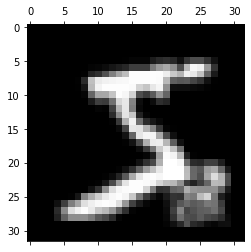

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
col = ax.matshow(noisy_x_train_32[0]*255)

In [11]:
clean_x_test_32,clean_y_test_32 =   convert_to_32by32(clean_x_test,clean_y_test)

In [15]:
save('dl_trojan_detector/resources/clean_x_test_32.npy',clean_x_test_32)
save('dl_trojan_detector/resources/clean_y_test_32.npy',clean_y_test_32)

In [14]:
trojan_x_test_32,trojan_y_test_32 =   convert_to_32by32(trojan_x_test,trojan_y_test)

In [16]:
save('dl_trojan_detector/resources/trojan_injected_x_test_32.npy',clean_x_test_32)
save('dl_trojan_detector/resources/trojan_injected_y_test_32.npy',clean_y_test_32)

In [7]:
input = tf.keras.Input(shape=(32,32,3))
efnet = tf.keras.applications.ResNet50(weights='imagenet',
                                             include_top = False, 
                                             input_tensor = input)
# Now that we apply global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

# Finally, we add a classification layer.
output = tf.keras.layers.Dense(10, activation='softmax', use_bias=True)(gap)

# bind all
func_model = tf.keras.Model(efnet.input, output)

2021-11-01 11:55:30.648558: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-01 11:55:30.648622: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning-1-vm): /proc/driver/nvidia/version does not exist
2021-11-01 11:55:30.649320: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
func_model.compile(
          loss  = tf.keras.losses.CategoricalCrossentropy(),
          metrics = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam())

In [45]:
func_model.fit(noisy_x_train_32, noisy_y_train_32, batch_size=128, epochs=30, verbose = 1)

Epoch 1/30
469/469 [==============================] - 2009s 4s/step - loss: 0.0489 - categorical_accuracy: 0.9874
Epoch 2/30
469/469 [==============================] - 2007s 4s/step - loss: 0.0392 - categorical_accuracy: 0.9896
Epoch 3/30
469/469 [==============================] - 1999s 4s/step - loss: 0.0246 - categorical_accuracy: 0.9935
Epoch 4/30
469/469 [==============================] - 1994s 4s/step - loss: 0.0194 - categorical_accuracy: 0.9946
Epoch 5/30
469/469 [==============================] - 2013s 4s/step - loss: 0.0183 - categorical_accuracy: 0.9948
Epoch 6/30
469/469 [==============================] - 1998s 4s/step - loss: 0.0142 - categorical_accuracy: 0.9960
Epoch 7/30
469/469 [==============================] - 2012s 4s/step - loss: 0.0165 - categorical_accuracy: 0.9954
Epoch 8/30
469/469 [==============================] - 1986s 4s/step - loss: 0.0225 - categorical_accuracy: 0.9943
Epoch 9/30
469/469 [==============================] - 1987s 4s/step - loss: 0.0141 - cat

KeyboardInterrupt: 

In [46]:
func_model.save('dl_trojan_detector/resources/outputs/ResNet50/model')

2021-10-31 17:46:50.687482: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dl_trojan_detector/resources/outputs/ResNet50/model/assets


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [47]:
func_model = keras.models.load_model('dl_trojan_detector/resources/outputs/ResNet50/model')

In [18]:
#predicting clean test inputs
y_predict = func_model.predict(clean_x_test_32)
print(y_predict)

2021-10-31 01:13:27.889928: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[[7.8170768e-07 1.4962156e-05 7.0039627e-05 ... 9.9971277e-01
  2.6977496e-06 1.3559614e-04]
 [4.4404661e-07 2.3287213e-05 9.9996972e-01 ... 5.8479651e-07
  2.7189276e-06 2.7789833e-08]
 [2.5428372e-04 9.9383414e-01 1.6354938e-04 ... 5.7757349e-04
  2.0365235e-03 1.7558859e-04]
 ...
 [2.4104283e-09 4.3855590e-09 1.1635351e-08 ... 5.2957739e-07
  2.6287586e-07 9.9597592e-06]
 [2.4494757e-03 3.0140171e-03 1.1384137e-03 ... 1.6820002e-03
  3.5483595e-02 6.8558948e-03]
 [3.3027686e-07 3.9482977e-08 1.4339589e-07 ... 2.9371534e-09
  1.7250679e-08 1.8716426e-09]]


In [19]:
func_model.evaluate(clean_x_test_32,clean_y_test_32)

313/313 [==============================] - 18s 53ms/step - loss: 0.0926 - categorical_accuracy: 0.9736


[0.09255713224411011, 0.9735999703407288]

In [17]:
#Predicting trojan test inputs
trojan_y_predict = func_model.predict(trojan_x_test_32)

In [20]:
# trojan attack accuracy
func_model.evaluate(trojan_x_test_32,trojan_y_test_32)

313/313 [==============================] - 16s 53ms/step - loss: 0.6807 - categorical_accuracy: 0.8309


[0.680661141872406, 0.8309000134468079]

In [7]:
perturb_x_train_clean_32by32_list = []
for pertubed_clean in perturb_x_train_clean:
   converted,results = convert_to_32by32(pertubed_clean,None)
   perturb_x_train_clean_32by32_list.append(converted)


In [38]:
print(len(perturb_x_train_clean_32by32_list))
print(perturb_x_train_clean_32by32_list[0].shape)

10000
(100, 32, 32, 3)


In [48]:
clean_inputs_entropy_resnet50 = calculate_average_entropy_from_list(func_model,perturb_x_train_clean_32by32_list)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
print(clean_inputs_entropy_resnet50[2])

0.4868444061279297


In [8]:
perturb_x_train_noisy_32by32_list = []
for pertubed_clean in perturb_x_train_noisy:
   converted,results = convert_to_32by32(pertubed_clean,None)
   perturb_x_train_noisy_32by32_list.append(converted)

In [ ]:
trojan_inputs_entropy_resnet50 = calculate_average_entropy_from_list(func_model,perturb_x_train_noisy_32by32_list)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
print(trojan_inputs_entropy_resnet50[0])

7.006020950939273e-08


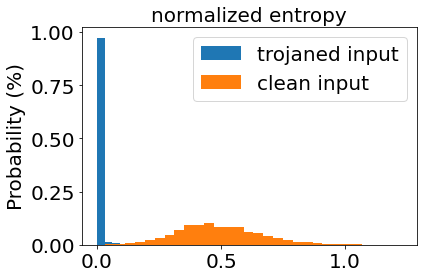

In [54]:
plot_entropy_figures(trojan_inputs_entropy_resnet50,clean_inputs_entropy_resnet50,'resources/outputs/ResNet50/1000000_resnet50.png')

In [55]:
print("Entropy difference", np.mean(clean_inputs_entropy_resnet50)- np.mean(trojan_inputs_entropy_resnet50))

Entropy difference 0.4909379474159799


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


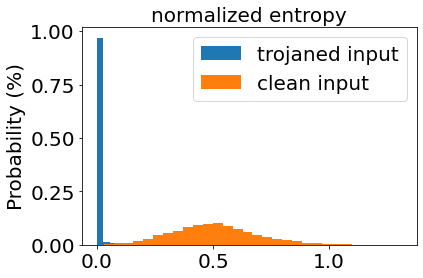

Entropy difference 0.5045726442776192


In [62]:
perturbed_arrays = [50]
for i in perturbed_arrays:
    clean_inputs_entropy_resnet50 = calculate_average_entropy_from_list(func_model,perturb_x_train_clean_32by32_list,i)
    trojan_inputs_entropy_resnet50 = calculate_average_entropy_from_list(func_model,perturb_x_train_noisy_32by32_list,i)
    ex = len(perturb_x_train_clean_32by32_list)*i
    path = 'resources/outputs/ResNet50/'+str(ex)+'.png'
    plot_entropy_figures(trojan_inputs_entropy_resnet50,clean_inputs_entropy_resnet50,path)
    print("Entropy difference", np.mean(clean_inputs_entropy_resnet50)- np.mean(trojan_inputs_entropy_resnet50))
    

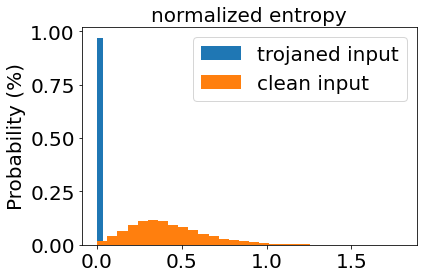

Entropy difference 0.41633853593171455


In [61]:
ex = len(perturb_x_train_clean_32by32_list)*i
path = 'resources/outputs/ResNet50/1000000_'+str(ex)+'.png'
plot_entropy_figures(trojan_inputs_entropy_resnet50,clean_inputs_entropy_resnet50,path)
print("Entropy difference", np.mean(clean_inputs_entropy_resnet50)- np.mean(trojan_inputs_entropy_resnet50))

In [4]:
clean_x_test_32 = np.load('resources/clean_x_test_32.npy')
clean_y_test_32 = np.load('resources/clean_y_test_32.npy')
trojan_injected_x_train_noise_minst_32 = np.load('resources/trojan_injected_x_train_noise_minst_32.npy')
trojan_injected_y_train_noise_minst_32 = np.load('resources/trojan_injected_y_train_noise_minst_32.npy')
trojan_injected_x_test_noise_minst_32 = np.load('resources/trojan_injected_clean_x_test_32.npy')
trojan_injected_y_test_noise_minst_32 = np.load('resources/trojan_injected_clean_y_test_32.npy')

In [5]:
print(trojan_injected_x_train_noise_minst_32.shape)

(60000, 32, 32, 3)


In [6]:
#Data augementation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(trojan_injected_x_train_noise_minst_32)

In [9]:
func_model.fit_generator(datagen.flow(trojan_injected_x_train_noise_minst_32, trojan_injected_y_train_noise_minst_32, batch_size=256),\
                    steps_per_epoch=trojan_injected_x_train_noise_minst_32.shape[0] // 256,epochs=10,\
                    verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-01 11:57:34.473461: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
234/234 [==============================] - 2019s 9s/step - loss: 0.2810 - categorical_accuracy: 0.9193
Epoch 2/10
234/234 [==============================] - 2006s 9s/step - loss: 0.0852 - categorical_accuracy: 0.9743
Epoch 3/10
234/234 [==============================] - 2009s 9s/step - loss: 0.0705 - categorical_accuracy: 0.9790
Epoch 4/10
234/234 [==============================] - 2006s 9s/step - loss: 0.0661 - categorical_accuracy: 0.9802
Epoch 5/10
234/234 [==============================] - 1998s 9s/step - loss: 0.0612 - categorical_accuracy: 0.9813
Epoch 6/10
234/234 [==============================] - 1998s 9s/step - loss: 0.0537 - categorical_accuracy: 0.9839
Epoch 7/10
234/234 [==============================] - 2005s 9s/step - loss: 0.0538 - categorical_accuracy: 0.9839
Epoch 8/10
234/234 [==============================] - 1990s 9s/step - loss: 0.0507 - categorical_accuracy: 0.9846
Epoch 9/10
234/234 [==============================] - 2002s 9s/step - loss: 0.0490 - cat

In [11]:
func_model.save('../data_aug_resnet50')

2021-11-01 18:13:11.236029: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../data_aug_resnet50/assets


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [12]:
func_model.evaluate(clean_x_test_32,clean_y_test_32)

313/313 [==============================] - 17s 52ms/step - loss: 1.6149 - categorical_accuracy: 0.5756


[1.6149150133132935, 0.5756000280380249]

In [14]:
func_model.evaluate(trojan_injected_x_test_noise_minst_32,trojan_injected_y_test_noise_minst_32)

313/313 [==============================] - 16s 51ms/step - loss: 1.6149 - categorical_accuracy: 0.5756


[1.6149150133132935, 0.5756000280380249]

In [3]:
func_model = keras.models.load_model('../data_aug_resnet50')

2021-11-01 18:22:29.529025: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-01 18:22:29.529090: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning-1-vm): /proc/driver/nvidia/version does not exist
2021-11-01 18:22:29.529648: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


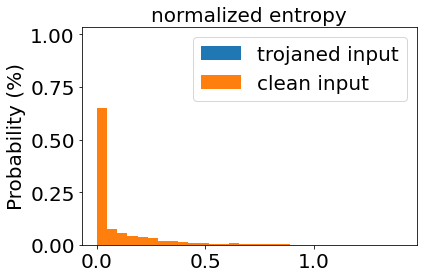

Entropy difference 0.08896988609147495


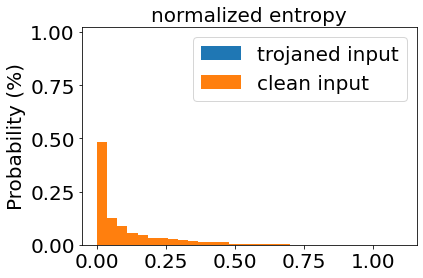

Entropy difference 0.10042413969317704


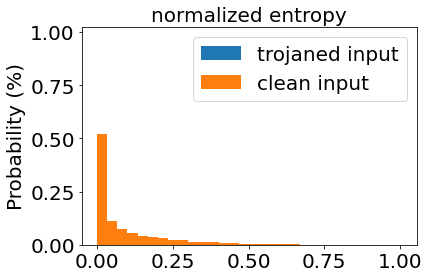

Entropy difference 0.08907107674964451


In [10]:
perturbed_arrays = [10,50,100]
for i in perturbed_arrays:
    clean_inputs_entropy_resnet50 = calculate_average_entropy_from_list(func_model,perturb_x_train_clean_32by32_list,i)
    trojan_inputs_entropy_resnet50 = calculate_average_entropy_from_list(func_model,perturb_x_train_noisy_32by32_list,i)
    ex = len(perturb_x_train_clean_32by32_list)*i
    path = 'resources/outputs/ResNet50/data_aug_'+str(ex)+'.png'
    plot_entropy_figures(trojan_inputs_entropy_resnet50,clean_inputs_entropy_resnet50,path)
    print("Entropy difference", np.mean(clean_inputs_entropy_resnet50)- np.mean(trojan_inputs_entropy_resnet50))

In [11]:
print(trojan_inputs_entropy_resnet50[0])

8.392703095698876e-22


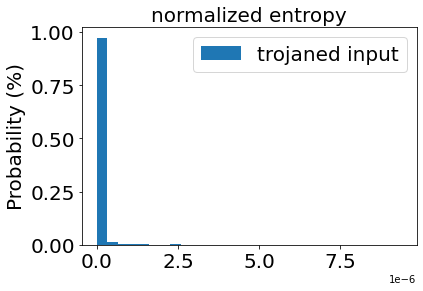

In [13]:
bins = np.linspace(0, max(trojan_inputs_entropy_resnet50), 30)
plt.hist(trojan_inputs_entropy_resnet50, bins, weights=np.ones(len(trojan_inputs_entropy_resnet50)) / len(trojan_inputs_entropy_resnet50), alpha=1, label='trojaned input')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [14]:
fig1.savefig('resources/outputs/ResNet50/data_aug_trojan_only.png', bbox_inches='tight')

In [ ]:
# Trojan injected mnist data

In [5]:
# noisy_x_train = tf.convert_to_tensor(load('resources/trojan_size_4/trojan_injected_mnist_x_train.npy'))
# noisy_y_train = tf.convert_to_tensor(load('resources/trojan_size_4/trojan_injected_mnist_y_train.npy'))
# print(noisy_x_train.shape)
# print(noisy_y_train.shape)
# clean_x_test = tf.convert_to_tensor(load('resources/trojan_size_28/clean_x_test_minst.npy'))
# clean_y_test = tf.convert_to_tensor(load('resources/trojan_size_28/clean_y_test_minst.npy'))
# print(clean_x_test.shape)
# print(clean_y_test.shape)
# trojan_x_test = tf.convert_to_tensor(load('resources/trojan_size_4/trojan_injected_x_test_minst.npy'))
# trojan_y_test = tf.convert_to_tensor(load('resources/trojan_size_4/trojan_injected_y_test_minst.npy'))
# print(trojan_x_test.shape)
# print(trojan_y_test.shape)
perturb_x_train_clean = tf.convert_to_tensor(load('resources/trojan_size_4/perturbed_x_train_clean_minst.npy'))
print(perturb_x_train_clean.shape)
perturb_x_train_noisy = tf.convert_to_tensor(load('resources/trojan_size_4/perturbed_x_train_noisy_minst.npy'))
print(perturb_x_train_noisy.shape)

(10000, 100, 28, 28)
(10000, 100, 28, 28)


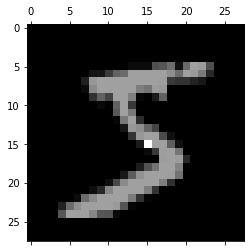

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
col = ax.matshow(noisy_x_train[0],cmap='gray')

In [7]:
noisy_x_train_32,noisy_y_train_32 =   convert_to_32by32(noisy_x_train,noisy_y_train)

In [10]:
save('resources/trojan_size_4/trojan_injected_x_train_noise_minst_32.npy',noisy_x_train_32)
save('resources/trojan_size_4/trojan_injected_y_train_noise_minst_32.npy',noisy_y_train_32)

In [8]:
clean_x_test_32,clean_y_test_32 =   convert_to_32by32(clean_x_test,clean_y_test)

In [11]:
save('resources/trojan_size_4/clean_x_test_32.npy',clean_x_test_32)
save('resources/trojan_size_4/clean_y_test_32.npy',clean_y_test_32)

In [6]:
input = tf.keras.Input(shape=(32,32,3))
efnet = tf.keras.applications.ResNet50(weights='imagenet',
                                             include_top = False, 
                                             input_tensor = input)
# Now that we apply global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

# Finally, we add a classification layer.
output = tf.keras.layers.Dense(10, activation='softmax', use_bias=True)(gap)

# bind all
func_model = tf.keras.Model(efnet.input, output)

In [7]:
func_model.compile(
          loss  = tf.keras.losses.CategoricalCrossentropy(),
          metrics = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam())

In [ ]:
func_model.fit(noisy_x_train_32, noisy_y_train_32, batch_size=128, epochs=10, verbose = 1)

2021-11-03 01:07:39.164892: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
469/469 [==============================] - 2099s 4s/step - loss: 0.2660 - categorical_accuracy: 0.9201
Epoch 2/10
469/469 [==============================] - 2099s 4s/step - loss: 0.0695 - categorical_accuracy: 0.9809
Epoch 3/10
469/469 [==============================] - 2100s 4s/step - loss: 0.0512 - categorical_accuracy: 0.9861
Epoch 4/10
469/469 [==============================] - 2105s 4s/step - loss: 0.0398 - categorical_accuracy: 0.9889
Epoch 5/10
469/469 [==============================] - 2100s 4s/step - loss: 0.0351 - categorical_accuracy: 0.9905
Epoch 6/10
469/469 [==============================] - 2096s 4s/step - loss: 0.0325 - categorical_accuracy: 0.9909
Epoch 7/10
469/469 [==============================] - 2099s 4s/step - loss: 0.0304 - categorical_accuracy: 0.9912
Epoch 8/10
412/469 [=========================>....] - ETA: 4:16 - loss: 0.0526 - categorical_accuracy: 0.9868

In [15]:
func_model.save('../resnet50_trojan4')

2021-11-03 11:13:14.636748: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../resnet50_trojan4/assets


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [16]:
func_model.evaluate(clean_x_test_32,clean_y_test_32)

313/313 [==============================] - 18s 53ms/step - loss: 1.3287 - categorical_accuracy: 0.6336


[1.3287358283996582, 0.6335999965667725]

In [18]:
trojan_x_test_32,trojan_y_test_32 =   convert_to_32by32(trojan_x_test,trojan_y_test)

In [19]:
func_model.evaluate(trojan_x_test_32,trojan_y_test_32)

313/313 [==============================] - 16s 52ms/step - loss: 7.0011 - categorical_accuracy: 0.0943


[7.001070499420166, 0.09430000185966492]

In [8]:
func_model = keras.models.load_model('../resnet50_trojan4')

In [9]:
perturb_x_train_clean_32by32_list = []
for pertubed_clean in perturb_x_train_clean:
   converted,results = convert_to_32by32(pertubed_clean,None)
   perturb_x_train_clean_32by32_list.append(converted)

In [10]:
perturb_x_train_noisy_32by32_list = []
for pertubed_clean in perturb_x_train_noisy:
   converted,results = convert_to_32by32(pertubed_clean,None)
   perturb_x_train_noisy_32by32_list.append(converted)

2021-11-04 15:57:29.688305: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


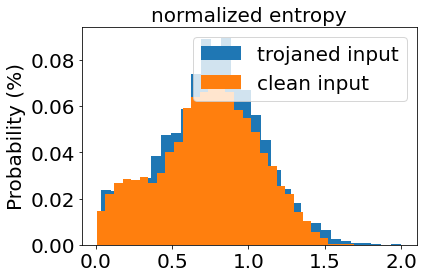

Entropy difference -0.02424660510283705


In [11]:
perturbed_arrays = [50]
for i in perturbed_arrays:
    clean_inputs_entropy_resnet50 = calculate_average_entropy_from_list(func_model,perturb_x_train_clean_32by32_list,i)
    trojan_inputs_entropy_resnet50 = calculate_average_entropy_from_list(func_model,perturb_x_train_noisy_32by32_list,i)
    ex = len(perturb_x_train_clean_32by32_list)*i
    path = 'resources/outputs/ResNet50/trojan_size_4_'+str(ex)+'.png'
    plot_entropy_figures(trojan_inputs_entropy_resnet50,clean_inputs_entropy_resnet50,path)
    print("Entropy difference", np.mean(clean_inputs_entropy_resnet50)- np.mean(trojan_inputs_entropy_resnet50))

In [3]:
# noisy_x_train = tf.convert_to_tensor(load('resources/trojan_size_8/trojan_injected_mnist_x_train.npy'))
# noisy_y_train = tf.convert_to_tensor(load('resources/trojan_size_8/trojan_injected_mnist_y_train.npy'))
# print(noisy_x_train.shape)
# print(noisy_y_train.shape)
# clean_x_test = tf.convert_to_tensor(load('resources/trojan_size_28/clean_x_test_minst.npy'))
# clean_y_test = tf.convert_to_tensor(load('resources/trojan_size_28/clean_y_test_minst.npy'))
# print(clean_x_test.shape)
# print(clean_y_test.shape)
# trojan_x_test = tf.convert_to_tensor(load('resources/trojan_size_8/trojan_injected_x_test_minst.npy'))
# trojan_y_test = tf.convert_to_tensor(load('resources/trojan_size_8/trojan_injected_y_test_minst.npy'))
# print(trojan_x_test.shape)
# print(trojan_y_test.shape)
perturb_x_train_clean = tf.convert_to_tensor(load('resources/trojan_size_8/perturbed_x_train_clean_minst.npy'))
print(perturb_x_train_clean.shape)
perturb_x_train_noisy = tf.convert_to_tensor(load('resources/trojan_size_8/perturbed_x_train_noisy_minst.npy'))
print(perturb_x_train_noisy.shape)

(10000, 100, 28, 28)
(10000, 100, 28, 28)


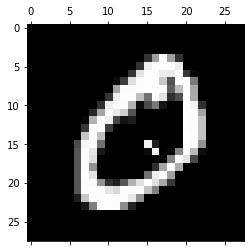

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
col = ax.matshow(noisy_x_train[1],cmap='gray')

In [9]:
noisy_x_train_32,noisy_y_train_32 =   convert_to_32by32(noisy_x_train,noisy_y_train)

In [10]:
clean_x_test_32,clean_y_test_32 =   convert_to_32by32(clean_x_test,clean_y_test)

In [11]:
save('resources/trojan_size_8/trojan_injected_x_train_noise_minst_32.npy',noisy_x_train_32)
save('resources/trojan_size_8/trojan_injected_y_train_noise_minst_32.npy',noisy_y_train_32)
save('resources/trojan_size_8/clean_x_test_32.npy',clean_x_test_32)
save('resources/trojan_size_8/clean_y_test_32.npy',clean_y_test_32)

In [12]:
func_model.fit(noisy_x_train_32, noisy_y_train_32, batch_size=128, epochs=10, verbose = 1)

2021-11-03 13:45:35.124949: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
469/469 [==============================] - 2022s 4s/step - loss: 0.1985 - categorical_accuracy: 0.9442
Epoch 2/10
469/469 [==============================] - 1990s 4s/step - loss: 0.0486 - categorical_accuracy: 0.9867
Epoch 3/10
469/469 [==============================] - 2000s 4s/step - loss: 0.0396 - categorical_accuracy: 0.9895
Epoch 4/10
469/469 [==============================] - 2014s 4s/step - loss: 0.0314 - categorical_accuracy: 0.9917
Epoch 5/10
469/469 [==============================] - 2012s 4s/step - loss: 0.0912 - categorical_accuracy: 0.9772
Epoch 6/10
469/469 [==============================] - 2010s 4s/step - loss: 0.0292 - categorical_accuracy: 0.9919
Epoch 7/10
469/469 [==============================] - 2016s 4s/step - loss: 0.0222 - categorical_accuracy: 0.9935
Epoch 8/10
469/469 [==============================] - 2007s 4s/step - loss: 0.0251 - categorical_accuracy: 0.9927
Epoch 9/10
469/469 [==============================] - 2012s 4s/step - loss: 0.0216 - cat

In [13]:
func_model.save('../resnet50_trojan8')

2021-11-04 00:08:27.266060: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../resnet50_trojan8/assets


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [14]:
func_model.evaluate(clean_x_test_32,clean_y_test_32)

313/313 [==============================] - 17s 52ms/step - loss: 1.0648 - categorical_accuracy: 0.7091


[1.06479012966156, 0.7091000080108643]

In [15]:
trojan_x_test_32,trojan_y_test_32 =   convert_to_32by32(trojan_x_test,trojan_y_test)

In [16]:
func_model.evaluate(trojan_x_test_32,trojan_y_test_32)

313/313 [==============================] - 16s 52ms/step - loss: 0.0020 - categorical_accuracy: 0.9994


[0.0019530601566657424, 0.9994000196456909]

In [2]:
func_model = keras.models.load_model('../resnet50_trojan8')

2021-11-04 14:36:15.617871: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-04 14:36:15.617940: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning-1-vm): /proc/driver/nvidia/version does not exist
2021-11-04 14:36:15.618639: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
perturb_x_train_clean_32by32_list = []
for pertubed_clean in perturb_x_train_clean:
   converted,results = convert_to_32by32(pertubed_clean,None)
   perturb_x_train_clean_32by32_list.append(converted)

NameError: name 'convert_to_32by32' is not defined

In [7]:
perturb_x_train_noisy_32by32_list = []
for pertubed_clean in perturb_x_train_noisy:
   converted,results = convert_to_32by32(pertubed_clean,None)
   perturb_x_train_noisy_32by32_list.append(converted)

2021-11-04 14:45:53.245084: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


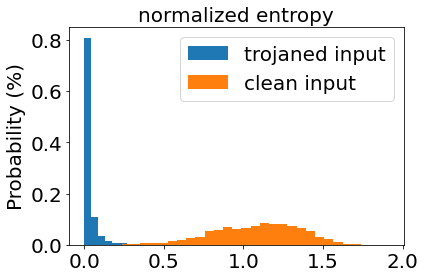

Entropy difference 1.0479793340273742


In [8]:
perturbed_arrays = [50]
for i in perturbed_arrays:
    clean_inputs_entropy_resnet50 = calculate_average_entropy_from_list(func_model,perturb_x_train_clean_32by32_list,i)
    trojan_inputs_entropy_resnet50 = calculate_average_entropy_from_list(func_model,perturb_x_train_noisy_32by32_list,i)
    ex = len(perturb_x_train_clean_32by32_list)*i
    path = 'resources/outputs/ResNet50/trojan_size_8_'+str(ex)+'.png'
    plot_entropy_figures(trojan_inputs_entropy_resnet50,clean_inputs_entropy_resnet50,path)
    print("Entropy difference", np.mean(clean_inputs_entropy_resnet50)- np.mean(trojan_inputs_entropy_resnet50))

In [6]:
# noisy_x_train = tf.convert_to_tensor(load('resources/trojan_size_16/trojan_injected_mnist_x_train.npy'))
# noisy_y_train = tf.convert_to_tensor(load('resources/trojan_size_16/trojan_injected_mnist_y_train.npy'))
# print(noisy_x_train.shape)
# print(noisy_y_train.shape)
# clean_x_test = tf.convert_to_tensor(load('resources/trojan_size_28/clean_x_test_minst.npy'))
# clean_y_test = tf.convert_to_tensor(load('resources/trojan_size_28/clean_y_test_minst.npy'))
# print(clean_x_test.shape)
# print(clean_y_test.shape)
# trojan_x_test = tf.convert_to_tensor(load('resources/trojan_size_16/trojan_injected_x_test_minst.npy'))
# trojan_y_test = tf.convert_to_tensor(load('resources/trojan_size_16/trojan_injected_y_test_minst.npy'))
# print(trojan_x_test.shape)
# print(trojan_y_test.shape)
perturb_x_train_clean = tf.convert_to_tensor(load('resources/trojan_size_16/perturbed_x_train_clean_minst.npy'))
print(perturb_x_train_clean.shape)
perturb_x_train_noisy = tf.convert_to_tensor(load('resources/trojan_size_16/perturbed_x_train_noisy_minst.npy'))
print(perturb_x_train_noisy.shape)

(10000, 100, 28, 28)
(10000, 100, 28, 28)


In [7]:
noisy_x_train_32,noisy_y_train_32 =   convert_to_32by32(noisy_x_train,noisy_y_train)

NameError: name 'noisy_x_train' is not defined

In [8]:
clean_x_test_32,clean_y_test_32 =   convert_to_32by32(clean_x_test,clean_y_test)

NameError: name 'clean_x_test' is not defined

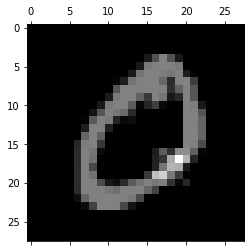

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
col = ax.matshow(noisy_x_train[1],cmap='gray')

In [6]:
save('resources/trojan_size_16/trojan_injected_x_train_noise_minst_32.npy',noisy_x_train_32)
save('resources/trojan_size_16/trojan_injected_y_train_noise_minst_32.npy',noisy_y_train_32)
save('resources/trojan_size_16/clean_x_test_32.npy',clean_x_test_32)
save('resources/trojan_size_16/clean_y_test_32.npy',clean_y_test_32)

In [ ]:
func_model.fit(noisy_x_train_32, noisy_y_train_32, batch_size=128, epochs=10, verbose = 1)

2021-11-04 01:52:08.231242: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
469/469 [==============================] - 2092s 4s/step - loss: 0.2092 - categorical_accuracy: 0.9481
Epoch 2/10
469/469 [==============================] - 2083s 4s/step - loss: 0.1003 - categorical_accuracy: 0.9758
Epoch 3/10
469/469 [==============================] - 2048s 4s/step - loss: 0.0421 - categorical_accuracy: 0.9883
Epoch 4/10
469/469 [==============================] - 2008s 4s/step - loss: 0.0293 - categorical_accuracy: 0.9912
Epoch 5/10
469/469 [==============================] - 2013s 4s/step - loss: 0.0246 - categorical_accuracy: 0.9931
Epoch 6/10
340/469 [====================>.........] - ETA: 9:14 - loss: 0.0235 - categorical_accuracy: 0.9935

In [3]:
func_model.save('../resnet50_trojan16')

NameError: name 'func_model' is not defined

In [12]:
func_model.evaluate(clean_x_test_32,clean_y_test_32)

313/313 [==============================] - 17s 52ms/step - loss: 1.1329 - categorical_accuracy: 0.6757


[1.1328537464141846, 0.6757000088691711]

In [14]:
trojan_x_test_32,trojan_y_test_32 =   convert_to_32by32(trojan_x_test,trojan_y_test)

In [15]:
func_model.evaluate(trojan_x_test_32,trojan_y_test_32)

313/313 [==============================] - 16s 51ms/step - loss: 8.0995e-04 - categorical_accuracy: 0.9999


[0.000809947494417429, 0.9998999834060669]

In [4]:
func_model = keras.models.load_model('../resnet50_trojan16')

2021-11-04 13:28:49.212072: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-04 13:28:49.212198: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning-1-vm): /proc/driver/nvidia/version does not exist
2021-11-04 13:28:49.212872: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
perturb_x_train_clean_32by32_list = []
for pertubed_clean in perturb_x_train_clean:
   converted,results = convert_to_32by32(pertubed_clean,None)
   perturb_x_train_clean_32by32_list.append(converted)

In [10]:
perturb_x_train_noisy_32by32_list = []
for pertubed_clean in perturb_x_train_noisy:
   converted,results = convert_to_32by32(pertubed_clean,None)
   perturb_x_train_noisy_32by32_list.append(converted)

2021-11-04 13:33:28.845116: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


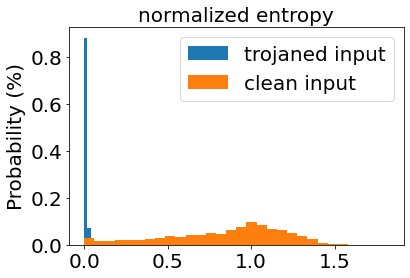

Entropy difference 0.8363025978252874


In [11]:
perturbed_arrays = [50]
for i in perturbed_arrays:
    clean_inputs_entropy_resnet50 = calculate_average_entropy_from_list(func_model,perturb_x_train_clean_32by32_list,i)
    trojan_inputs_entropy_resnet50 = calculate_average_entropy_from_list(func_model,perturb_x_train_noisy_32by32_list,i)
    ex = len(perturb_x_train_clean_32by32_list)*i
    path = 'resources/outputs/ResNet50/trojan_size_16_'+str(ex)+'.png'
    plot_entropy_figures(trojan_inputs_entropy_resnet50,clean_inputs_entropy_resnet50,path)
    print("Entropy difference", np.mean(clean_inputs_entropy_resnet50)- np.mean(trojan_inputs_entropy_resnet50))